In [1]:
import pandas as pd

df = pd.read_csv("data/processed/train_ready.csv")
df.sample(2)


,capacitate motor,putere,rulaj,an fabricatie,age_years,marca,brand_category,model_simplified,caroserie,combustibil,...,color_maro_/_bej,color_alta_culoare,color_verde,power_to_displacement,power_per_liter,mileage_per_year,model_frequency,log_mileage,log_engine_size,pret_log
7302,1395,140,254500,2014,10,seat,budget,Leon,Hatchback,Benzina,...,0,0,0,100.358423,100.358423,23136.363636,180,12.447060,7.241366,8.648397
6713,1498,101,268700,2013,11,renault,budget,Megane,Break,Diesel,...,0,0,0,67.423231,67.423231,22391.666667,169,12.501355,7.312553,8.409831


In [ ]:
import pandas as pd
import numpy as np
import joblib
import os
import json
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)
from sklearn.ensemble import RandomForestRegressor


# ====================================================
# 1) SET TARGET
# ====================================================

X = df.drop(columns=["pret_log"])
y_log = df["pret_log"]

# Train-test split
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

# Identify feature types
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numeric_cols     = X.select_dtypes(exclude=["object"]).columns.tolist()


# ====================================================
# 2) PREPROCESSING PIPELINE
# ====================================================

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
        ("num", "passthrough", numeric_cols),
    ]
)


# ====================================================
# 3) LIGHTWEIGHT RANDOM FOREST (Render-friendly)
# ====================================================

rf = RandomForestRegressor(
    n_estimators=150,     # instead of 1000
    max_depth=15,         # instead of 20/None
    min_samples_split=4,
    min_samples_leaf=1,
    max_features=0.5,
    bootstrap=True,
    random_state=42
)

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("rf", rf)
])

pipeline.fit(X_train, y_train_log)


# ====================================================
# 4) METRICS
# ====================================================

y_pred_log = pipeline.predict(X_test)
y_pred     = np.expm1(y_pred_log)
y_true     = np.expm1(y_test_log)

rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_log))
r2_log   = r2_score(y_test_log, y_pred_log)

rmse_price = np.sqrt(mean_squared_error(y_true, y_pred))
mae_price  = mean_absolute_error(y_true, y_pred)
mape       = mean_absolute_percentage_error(y_true, y_pred) * 100
accuracy   = 100 - mape
r2_price   = r2_score(y_true, y_pred)

print("\n=== LOG-space Metrics ===")
print(f"RMSE_log: {rmse_log:.4f}")
print(f"R2_log:   {r2_log:.4f}")

print("\n=== PRICE Metrics (EUR) ===")
print(f"RMSE_price: {rmse_price:,.2f} EUR")
print(f"MAE_price:  {mae_price:,.2f} EUR")
print(f"R2_price:   {r2_price:.4f}")
print(f"  MAPE    : {mape:.2f}%")
print(f"  Accuracy: {accuracy:.2f}%")

# ====================================================
# 6) 20 RANDOM SAMPLE PREDICTIONS
# ====================================================
results = pd.DataFrame({
    "true_price": y_true,
    "pred_price": y_pred,
})

results["abs_error"]  = (results["true_price"] - results["pred_price"]).abs()
results["pct_error"]  = results["abs_error"] / results["true_price"] * 100

print("\n=== 20 random predictions (EUR) ===")
print(
    results
    .sample(20, random_state=42)
    .round({"true_price": 0, "pred_price": 0, "abs_error": 0, "pct_error": 2})
)

# ====================================================
# 7) FEATURE IMPORTANCES
# ====================================================
rf_best = pipeline.named_steps["rf"]
feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()

importances = pd.DataFrame({
    "feature": feature_names,
    "importance": rf_best.feature_importances_,
}).sort_values("importance", ascending=False)

print("\nTop 20 important features:")
print(importances.head(20))

# ====================================================
# 8) SAVE MODEL (~20–40 MB)
# ====================================================

os.makedirs("backend/models_storage/metadata", exist_ok=True)
model_path = "backend/models_storage/random_forest_light.pkl"

joblib.dump(pipeline, model_path)
model_size = os.path.getsize(model_path) / (1024*1024)
print(f"Model saved ({model_size:.2f} MB)")


# ====================================================
# 9) SAVE METADATA
# ====================================================

metadata = {
    "model_type": "RandomForestRegressor (lightweight)",
    "saved_at": datetime.now().isoformat(),
    "parameters": {
        "n_estimators": 150,
        "max_depth": 15,
        "min_samples_split": 4,
        "min_samples_leaf": 1,
        "max_features": 0.5,
        "bootstrap": True,
    },
    "metrics": {
        "rmse_log": float(rmse_log),
        "r2_log": float(r2_log),
        "rmse_price_eur": float(rmse_price),
        "mae_price_eur": float(mae_price),
        "mape_percent": float(mape),
        "accuracy_percent": float(accuracy),
    }
}

metadata_path = "backend/models_storage/metadata/random_forest_light_metadata.json"
with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=2)

print("Metadata saved.")



=== LOG-space Metrics ===
RMSE_log: 0.3326
R2_log:   0.7953

=== PRICE Metrics (EUR) ===
RMSE_price: 3,811.14 EUR
MAE_price:  1,803.00 EUR
R2_price:   0.7592
  MAPE    : 23.36%
  Accuracy: 76.64%

=== 20 random predictions (EUR) ===
      true_price  pred_price  abs_error  pct_error
2907      3250.0      2401.0      849.0      26.13
6201     14650.0     12887.0     1763.0      12.04
5927      9290.0     10511.0     1221.0      13.15
8615      6800.0      6938.0      138.0       2.03
8149      7800.0      4938.0     2862.0      36.69
4271      7000.0      8572.0     1572.0      22.46
7711     10900.0     12183.0     1283.0      11.77
7675      7350.0      5721.0     1629.0      22.16
6720      8250.0      6371.0     1879.0      22.78
6223      4499.0      4611.0      112.0       2.49
8156      1800.0      3496.0     1696.0      94.22
2944      4290.0      5853.0     1563.0      36.43
7845     26590.0     23031.0     3559.0      13.38
6703      4350.0      3621.0      729.0      16.77
3

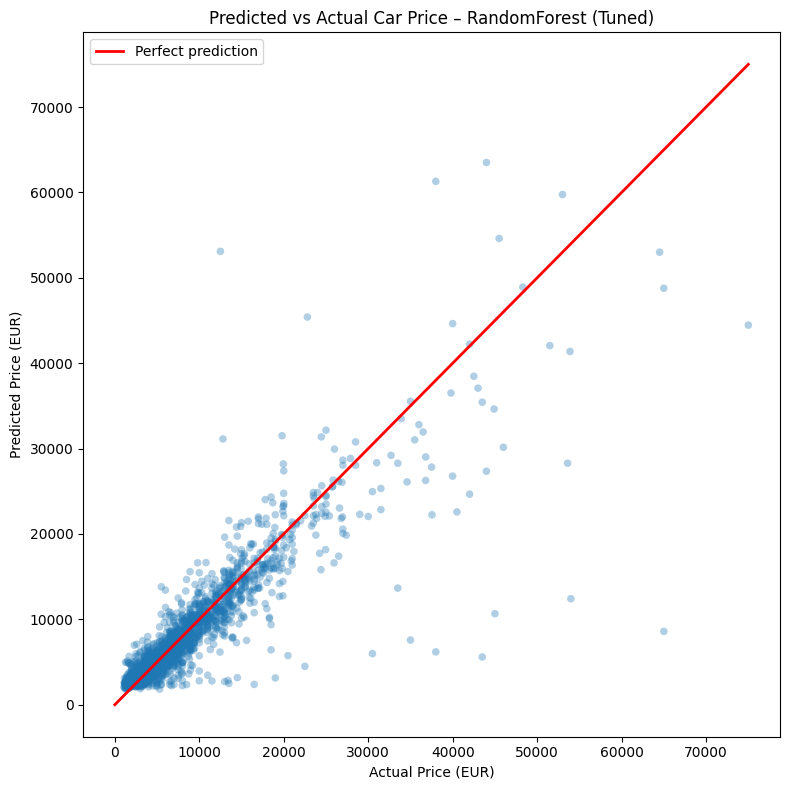

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt

# =====================================================
# RECOMPUTE TRUE & PREDICTED PRICES (EUR)
# =====================================================
y_true = np.expm1(y_test_log)  # actual prices in EUR
y_pred_log = pipeline.predict(X_test)
y_pred = np.expm1(y_pred_log)  # predicted prices in EUR

# =====================================================
# OUTPUT FOLDER
# =====================================================
os.makedirs("plots", exist_ok=True)

# =====================================================
# PLOT
# =====================================================
plt.figure(figsize=(8, 8))

plt.scatter(
    y_true,
    y_pred,
    alpha=0.35,
    s=30,
    edgecolors="none",
)

# Diagonal reference (perfect predictions)
min_p = 0
max_p = max(y_true.max(), y_pred.max())

plt.plot(
    [min_p, max_p],
    [min_p, max_p],
    color="red",
    linewidth=2,
    label="Perfect prediction",
)

plt.xlabel("Actual Price (EUR)")
plt.ylabel("Predicted Price (EUR)")
plt.title("Predicted vs Actual Car Price – RandomForest (Tuned)")

plt.legend()
plt.tight_layout()

plt.savefig("plots/rf__light_actual_vs_pred.png", dpi=180)
plt.show()
